# Lecture 10
_____________


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
import pandas as pd
from scipy import stats

## _Multisite generation_

Example - sampling from multivariate normal distribution

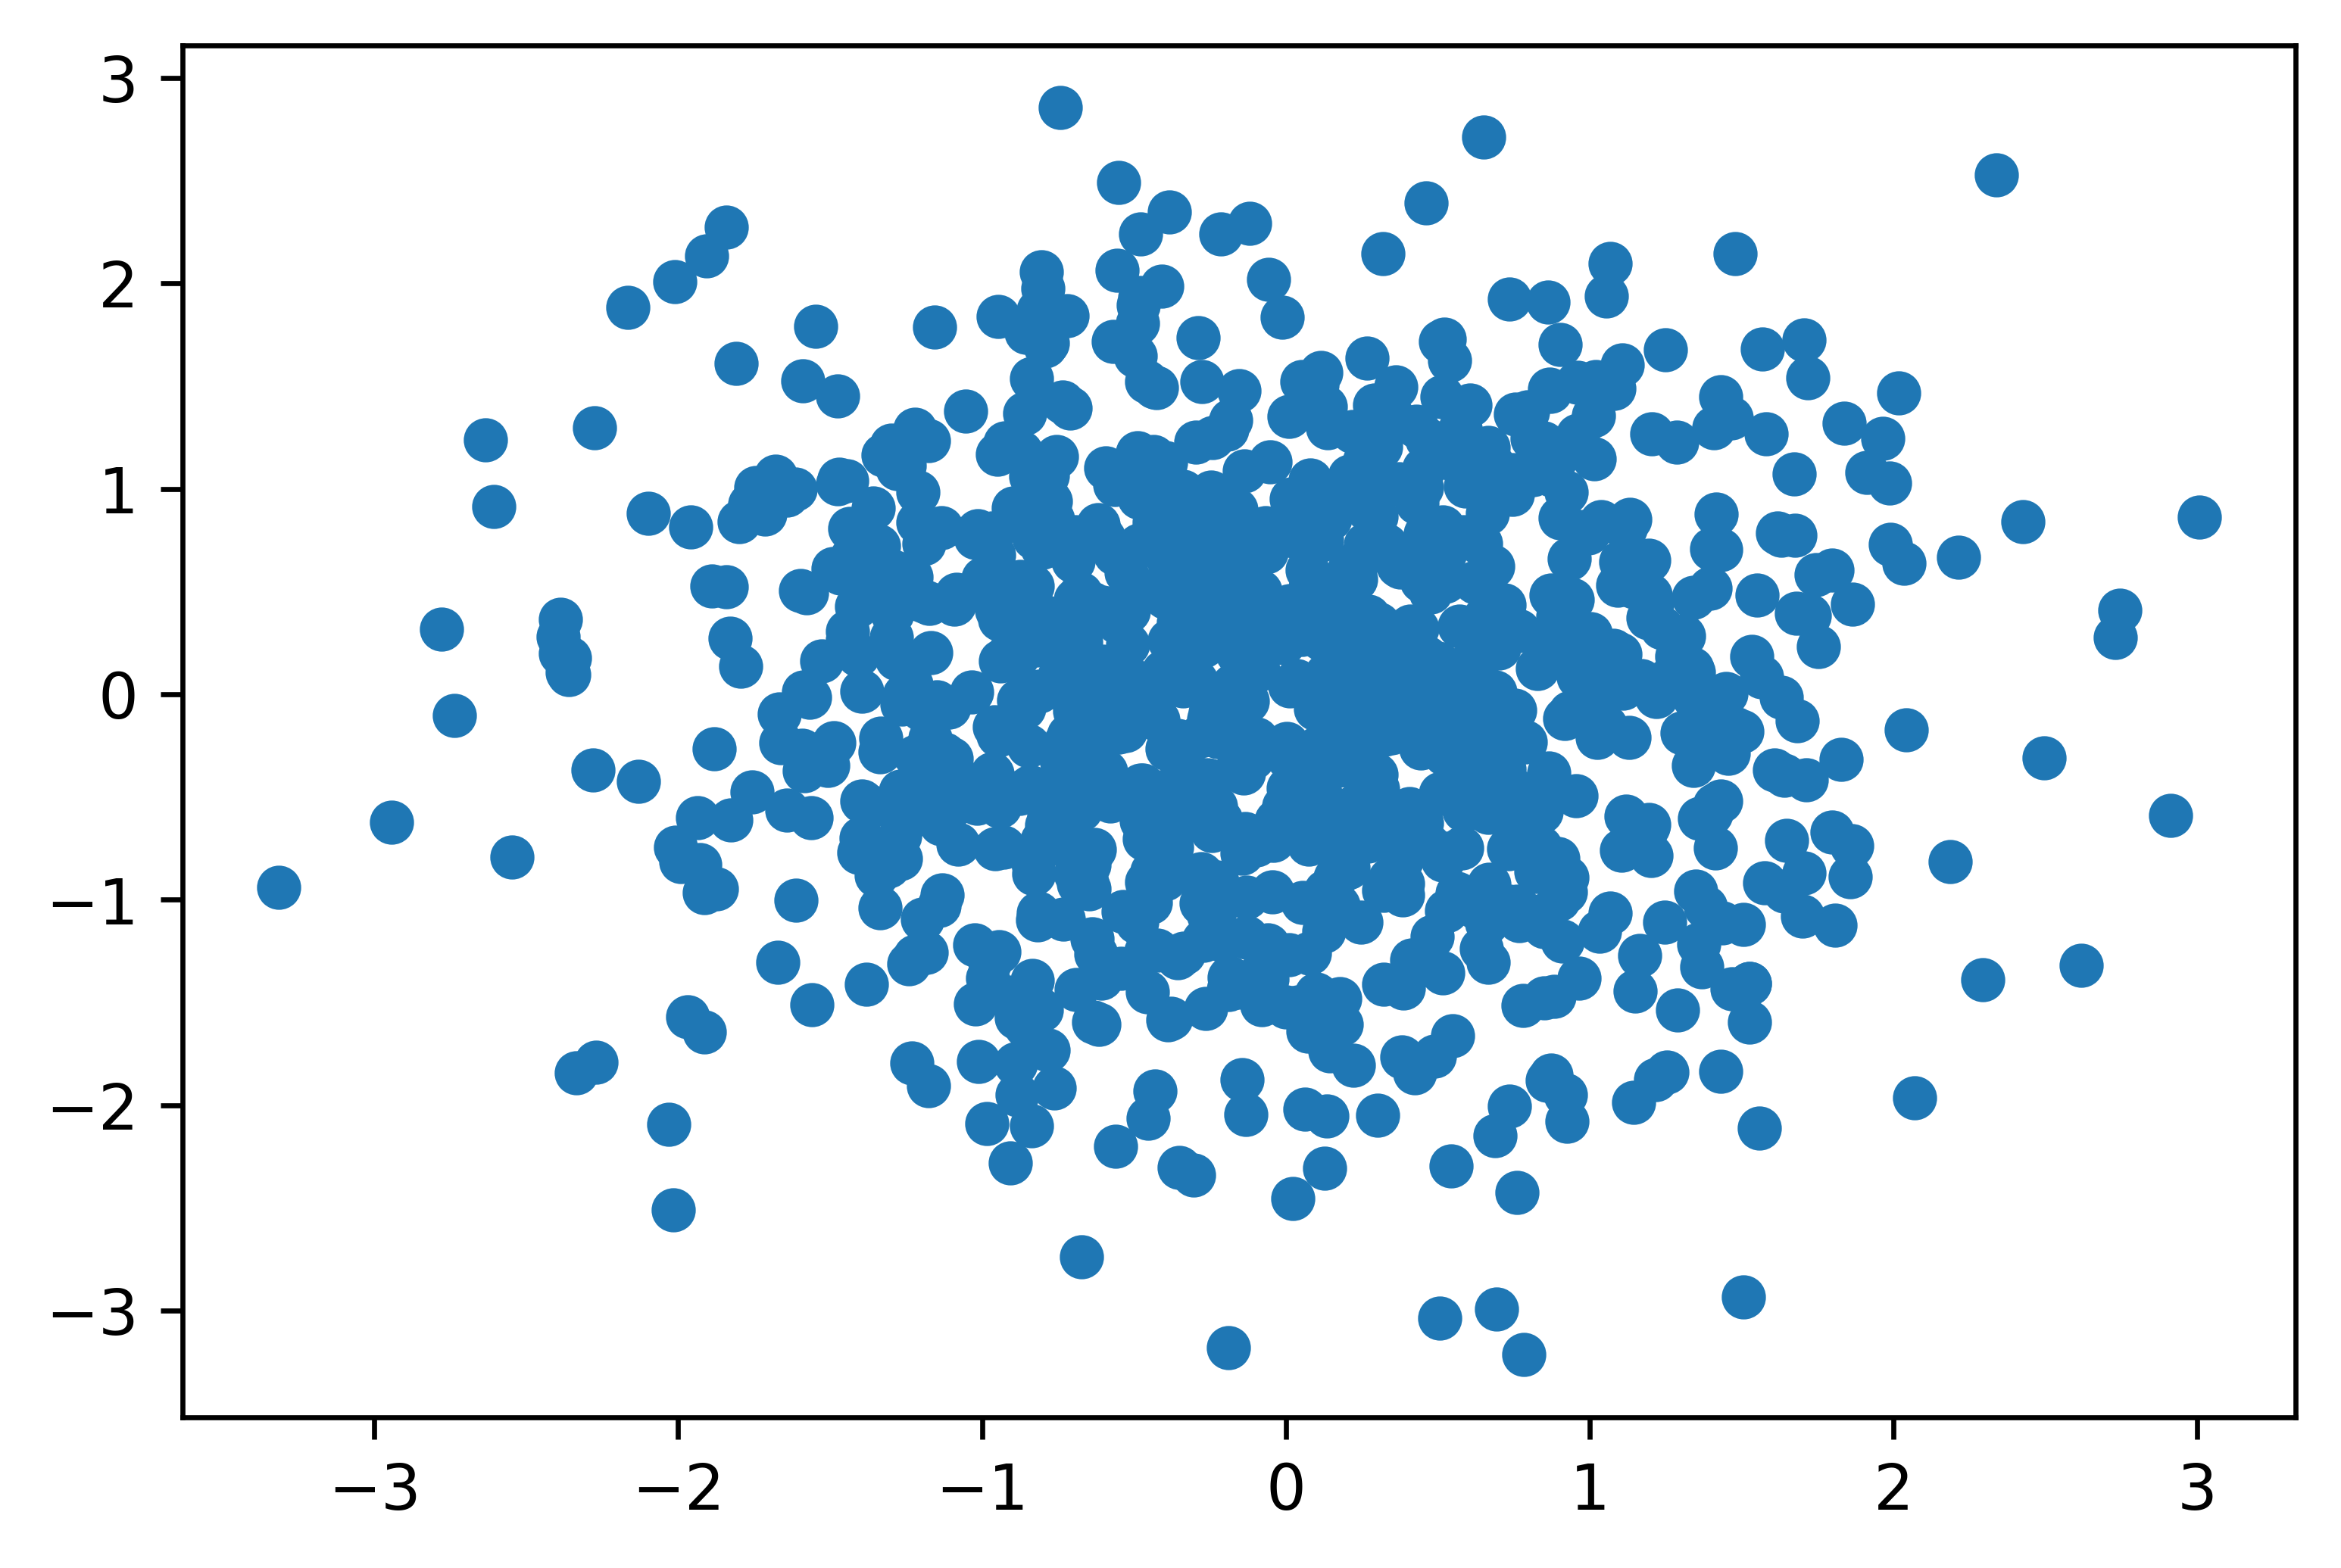

In [19]:
mu = [0,0]
Sigma = [[1,0], [0,1]] # no correlation
x = np.random.multivariate_normal(mu, Sigma, 1000)
plt.scatter(x[:,0], x[:,1])
plt.show()

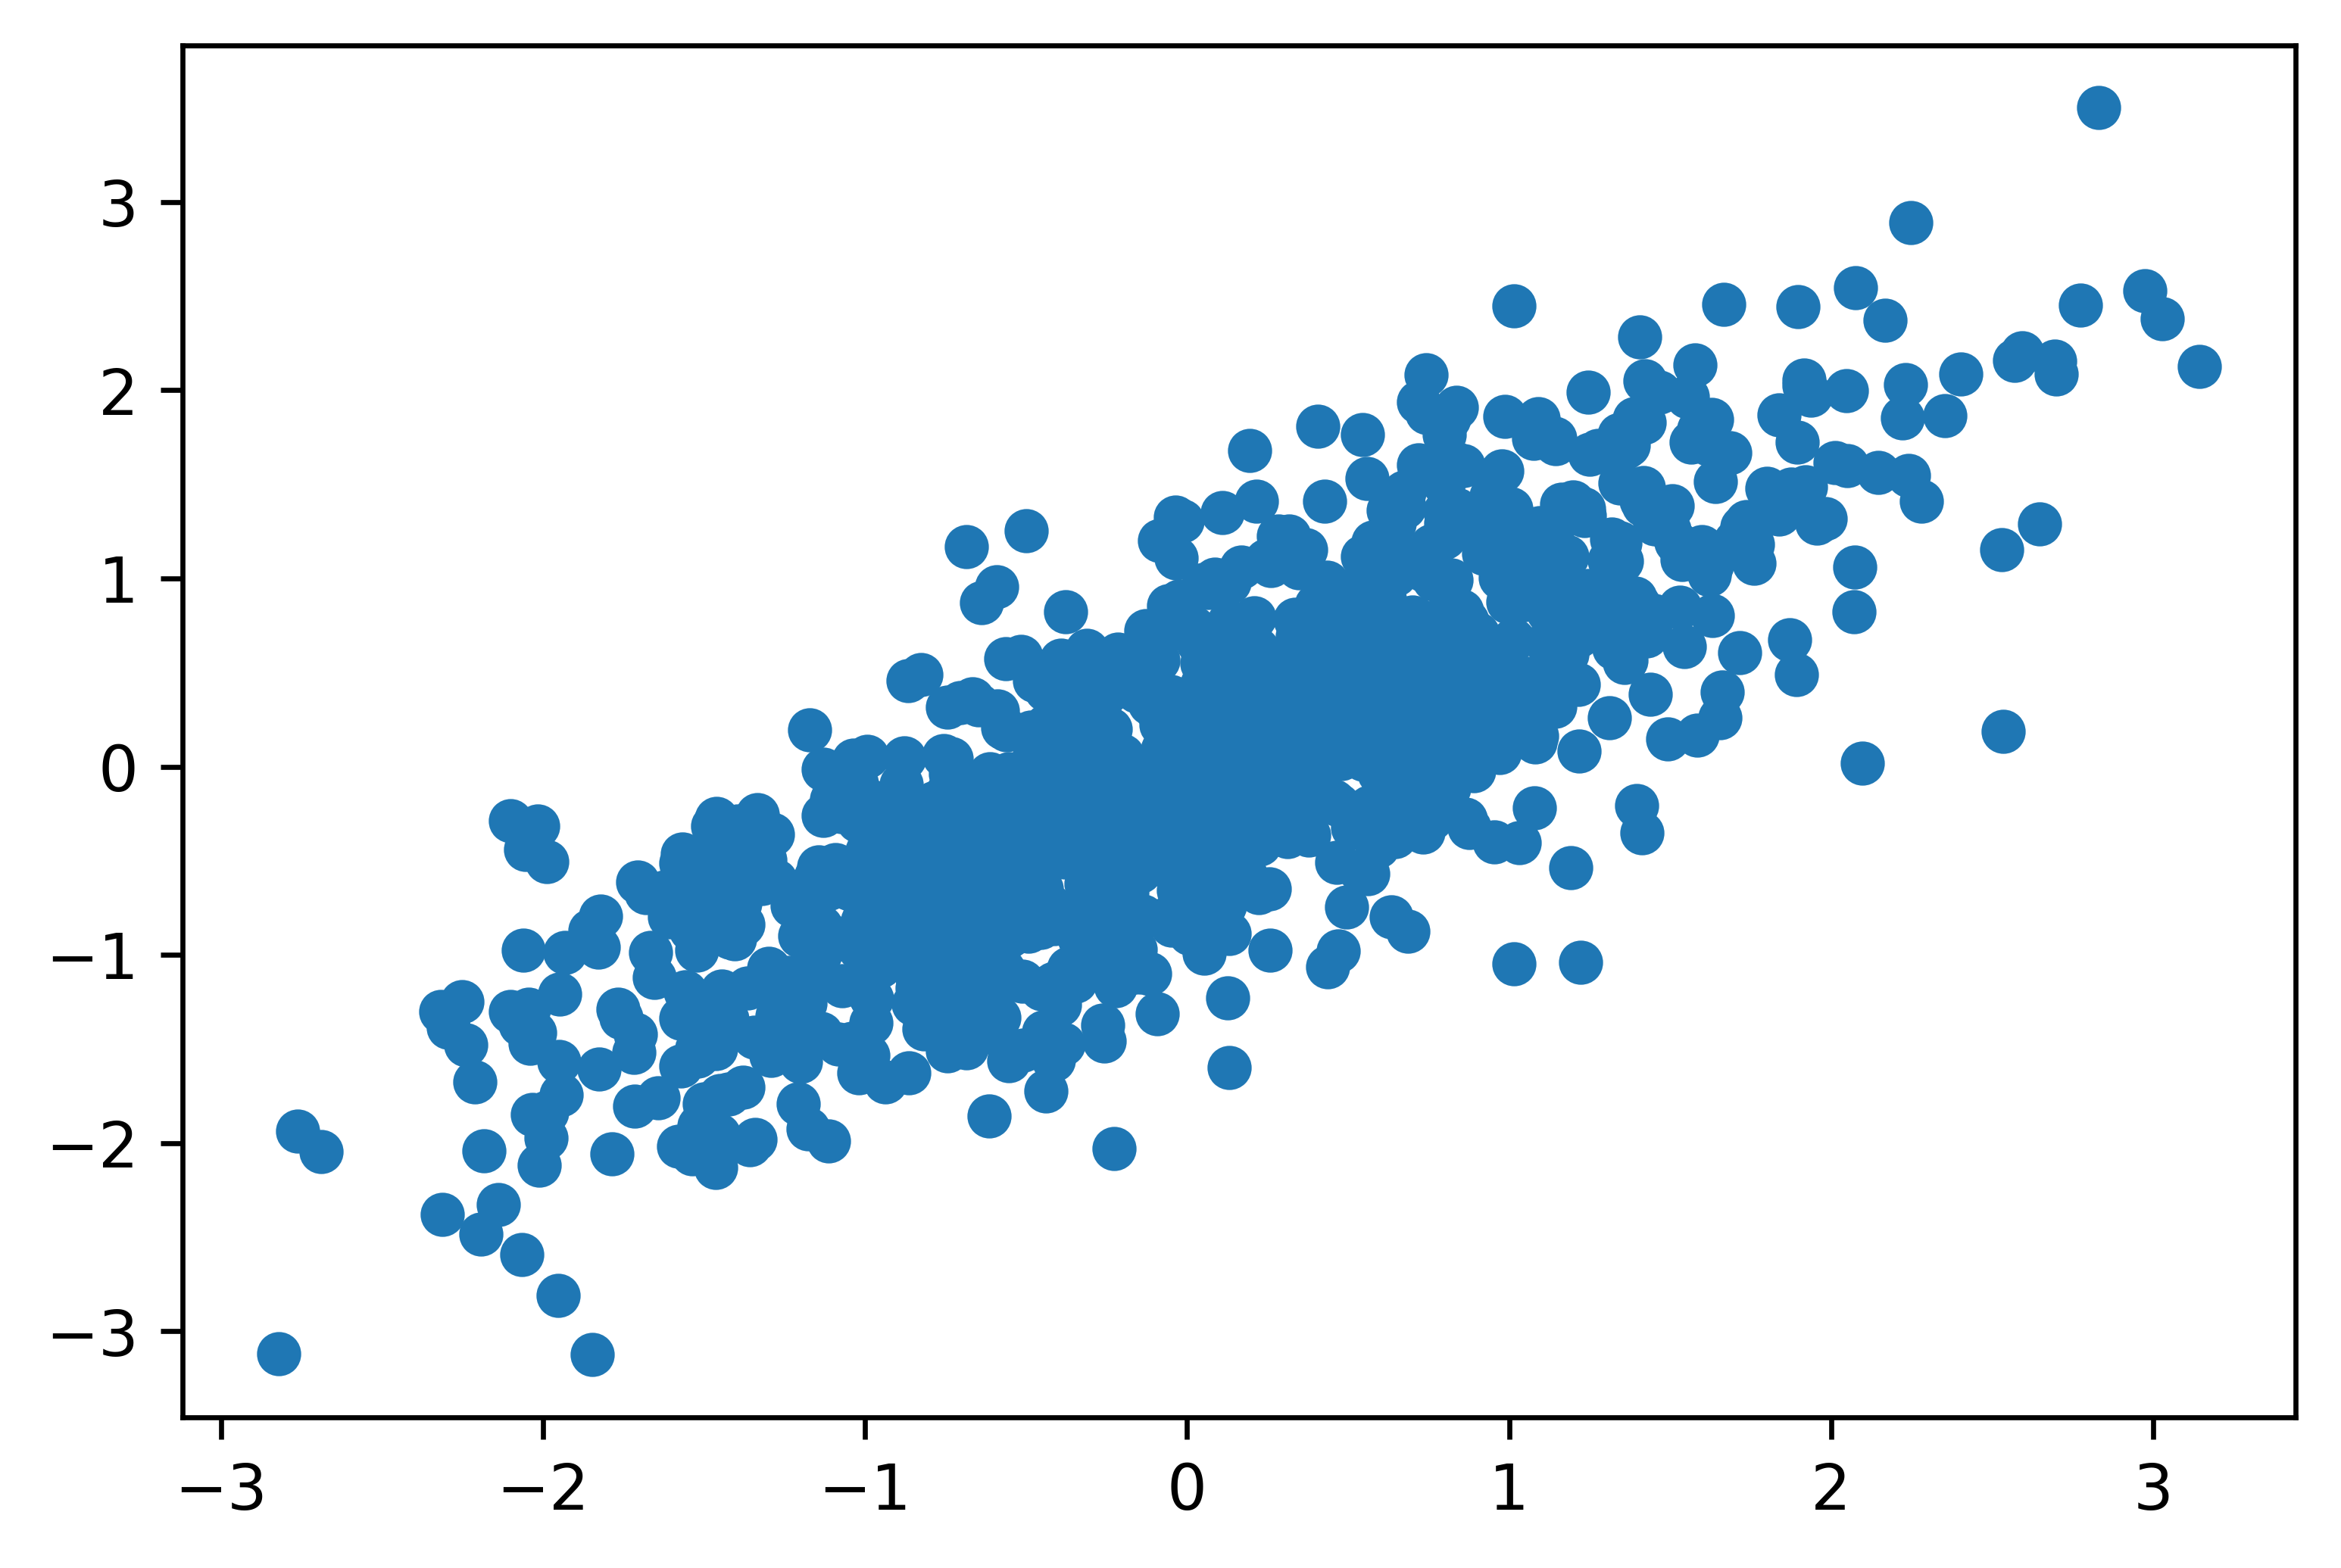

In [22]:
mu = [0,0]
Sigma = [[1,0.8], [0.8,1]] # add correlation
x = np.random.multivariate_normal(mu, Sigma, 1000)
plt.scatter(x[:,0], x[:,1])
plt.show()

We will use this function to generate multi-site synthetic streamflows.

In [23]:
cfs_to_tafd = 2.29568411*10**-5 * 86400 / 1000

In [24]:
def autocorr(x,k):
    '''returns the lag-k autocorrelation of vector x'''
    return np.corrcoef(x[:len(x)-k], x[k:])[0,1]

In [25]:
def thomasfiering(x1, x2, N):
    '''Lag-1 model for two sites. use historical data x 
    to generate a synthetic sequence of N timesteps.
    Assumes x is lognormally distributed.'''
    # this would be better in a loop
    # first location:
    x1 = np.log(x1) # log-space avoids negative values
    m1 = x1.mean()
    s1 = x1.std()
    r1 = autocorr(x1,1)
    Q1 = np.zeros(N) # initialize
    Q1[0] = np.random.normal(m1,s1,1) 
    
    # second location:
    x2 = np.log(x2) # log-space avoids negative values
    m2 = x2.mean()
    s2 = x2.std()
    r2 = autocorr(x2,1)
    Q2 = np.zeros(N) # initialize
    Q2[0] = np.random.normal(m2,s2,1) 
    
    Sigma = np.corrcoef(x1, x2) # sigma matrix
    # Sigma[0,1] = 0.5
    # Sigma[1,0] = 0.5
    for i in range(1,N):
        Z = np.random.multivariate_normal([0,0], Sigma, 1) # the 1 means we want 1 sample; or try 1000
        #plt.scatter(Z[:,0], Z[:,1])
        #plt.show()
        Q1[i] = m1 + r1*(Q1[i-1] - m1) + Z[0,0]*s1*np.sqrt(1-r1**2)
        Q2[i] = m2 + r2*(Q2[i-1] - m2) + Z[0,1]*s2*np.sqrt(1-r2**2)
    
    return np.exp(Q1), np.exp(Q2) # transform back to real space values at the end

Read in data and upscale to annual; rename the column we're going to use

This is an example of method chaining with pandas dataframes

It's not required to use multiple lines, but usually makes it more readable

In [26]:
dfF = (pd.read_csv('../data/FOL.csv', index_col=0, parse_dates=True)
         .rename(columns={'FOL_INFLOW_CFS':'inflow'}))
dfS = (pd.read_csv('../data/SHA.csv', index_col=0, parse_dates=True)
         .rename(columns={'SHA_INFLOW_CFS':'inflow'}))

dfS.inflow *= cfs_to_tafd
dfF.inflow *= cfs_to_tafd
dfS = dfS.resample('AS-OCT').sum()
dfF = dfF.resample('AS-OCT').sum()

Generate synthetic (input numpy arrays)

In [27]:
Q1, Q2 = thomasfiering(dfS.inflow.values, dfF.inflow.values, N=200)

Compare spatial correlation (this is in real space, not log)

In [28]:
print('Historical r = %0.3f' % np.corrcoef(dfS.inflow.values, 
                                           dfF.inflow.values)[0,1])
print('Synthetic r = %0.3f' % np.corrcoef(Q1, Q2)[0,1])

Historical r = 0.916
Synthetic r = 0.798


This is high correlation, but why is it different? 

The log-transformed data doesn't perfectly preserve correlation 

This is a large sample, but we're underestimating spatial correlation by a little bit

------------

## _Hypothesis testing_

In [29]:
def autocorr(x,k):
    '''returns the lag-k autocorrelation of vector x'''
    return np.corrcoef(x[:len(x)-k], x[k:])[0,1]

In [30]:
def thomasfiering(x,N):
    '''Lag-1 model. use historical data x 
    to generate a synthetic sequence of N timesteps.
    Assumes x is lognormally distributed.'''
    x = np.log(x) # log-space avoids negative values
    mu = x.mean()
    sigma = x.std()
    rho = autocorr(x,1)
    Q = np.zeros(N) # initialize
    Q[0] = np.random.normal(mu,sigma,1) 
    
    for i in range(1,N):
        Z = np.random.standard_normal()
        Q[i] = mu + rho*(Q[i-1] - mu) + Z*sigma*np.sqrt(1-rho**2)

    return np.exp(Q)

Assume annual flow data is lognormally distributed

This will avoid negative flows

In [31]:
Q = np.loadtxt('../data/folsom-annual-flow.csv', delimiter=',', skiprows=1, usecols=[1])
Q_synthetic = thomasfiering(Q, N=100)

In [32]:
print('Means: %f, %f' % (Q.mean(),Q_synthetic.mean()))
print('Stdev: %f, %f' % (Q.std(),Q_synthetic.std()))
print('Rho: %f, %f' % (autocorr(Q,1), autocorr(Q_synthetic,1)))
# note "retransformation bias" in rho

Means: 2729.264858, 2513.457158
Stdev: 1462.176198, 1470.724668
Rho: 0.051043, -0.058539


In [33]:
_, p = stats.ranksums(Q, Q_synthetic)

In [34]:
print('p = %0.4f' % p)

p = 0.2181


In [35]:
if p < 0.05:
    print('Reject null hypothesis that Q,Q_synth are from same distribution')
else:
    print('Fail to reject (this is a good thing)')

Fail to reject (this is a good thing)


-----------------